In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as api
import warnings
from joblib import Parallel,delayed
from dateutil.relativedelta import relativedelta
import os
import copy
warnings.filterwarnings('ignore')

In [2]:
old_path1 = 'D:/causis/factor/'
all_factor = [pd.read_csv(old_path1+path,index_col=0) for path in os.listdir(old_path1) if 'csv' in path]

In [3]:
os.listdir(old_path1)

['AdjustedProfitToProfit.csv',
 'BP.csv',
 'EP.csv',
 'GrossProfitMargin.csv',
 'IncNetProfitYearOnYear.csv',
 'IncRevenueYearOnYear.csv',
 'log_cap.csv',
 'NCFP.csv',
 'ROA.csv',
 'ROE.csv',
 'SP.csv',
 'std_12m.csv',
 'std_1m.csv',
 'std_3m.csv',
 'std_6m.csv',
 'turn_12m.csv',
 'turn_1m.csv',
 'turn_3m.csv',
 'turn_6m.csv']

In [4]:
#统一数据格式
for t in range(len(all_factor)):
    all_factor[t].index=pd.to_datetime(all_factor[t].index)#将索引改为时间序列
    all_factor[t]=all_factor[t]["20110101":"20201231"]#将索引对齐时间
    all_factor[t].index.name="date"
    
for t in range(len(all_factor)):
    all_factor[t].index=all_factor[1].index #将所有dataframe的索引改为每月末的交易日

def get_only(list_):  #取出共同列，即所有因子都包含的股票
    temp = []
    for factor in list_:
        temp = temp + list(factor.columns)
    return pd.Series(temp)

columns = get_only(all_factor)
columns = columns.value_counts().sort_index()
columns = columns[columns==columns.max()].index
all_factor = [factor[columns] for factor in all_factor]

In [5]:
#下面分别进行去极值、缺失值处理、中性化、标准化操作
#中位数去极值
def mad(factor,n=5):
    median = factor.median()
    new_median = np.abs(factor - median).median()
    max_value = median + n*new_median
    min_value = median - n*new_median
    return np.clip(factor,min_value,max_value)
#这里使用截面中位数填充
def fill_na(factor):
    factor=factor.fillna(factor.median())
    return factor
#标准化
def stand(factor):
    return (factor-factor.mean())/factor.std()

for i in range(len(all_factor)):
    all_factor[i]=all_factor[i].apply(lambda x:mad(x),axis=1)

for i in range(len(all_factor)):
    all_factor[i]=all_factor[i].apply(lambda x:fill_na(x),axis=1)
    
for i in range(len(all_factor)):
    all_factor[i]=all_factor[i].apply(lambda x:stand(x),axis=1)

In [6]:
corr_data = pd.concat([factor.T.stack() for factor in all_factor],axis=1)

<AxesSubplot:>

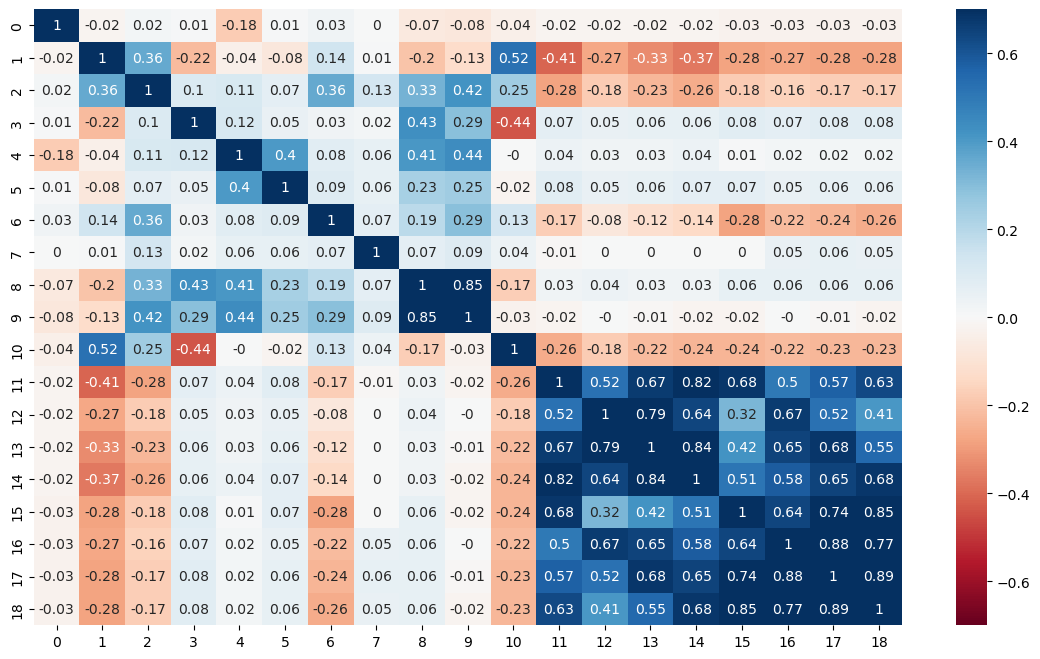

In [31]:
#这里展示因子之间的相关性
corr=corr_data.corr()
corr=round(corr,2)
f, ax= plt.subplots(figsize = (14, 8))
sns.heatmap(corr,cmap='RdBu',annot=True,ax=ax,vmax=0.7,vmin=-0.7)

In [6]:
#取出市值因子，为后面中性化操作做准备
log_cap=all_factor[6]
all_factor=all_factor[:6]+all_factor[7:]

In [7]:
#中性化
def neutralize(ser):
    log_cap_ser = log_cap.loc[ser.name]
    index = ~ser.isna() * ~log_cap_ser.isna()
    model = api.OLS(ser[index],api.add_constant(log_cap_ser[index])).fit()
    resid=pd.Series(model.resid,index=ser.index)
    return resid

for i in range(len(all_factor)):
    all_factor[i]=all_factor[i].apply(lambda x:neutralize(x),axis=1)

In [8]:
from sklearn.decomposition import PCA
pcadata=all_factor+[log_cap]
#构建pca数据接收池
dateindex=pcadata[0].index #取出索引为下面降维做准备
all_data=pd.concat(pcadata,axis=0) #将所有数据合并

In [12]:
variance_ratio=[]
transformdata=[]
for i in range(len(dateindex)):
    day_data=all_data.loc[dateindex[i]].T #取出当天所有因子对应的截面
    day_data=day_data[~day_data.isna().any(axis=1)] #取含有nan值的行全部去除
    day_dataindex=day_data.index #取出索引，最后一行代码生成dataframe时，与生成的值对应
    pca = PCA(n_components=11)#返回解释度为前11个的主成分
    pca.fit(day_data)
    variance_ratio.append(pca.explained_variance_ratio_.sum())
    transformdata.append((pd.DataFrame(pca.transform(day_data),index=day_dataindex)).T)

In [13]:
#平均主成分解释度
np.array(variance_ratio).mean()

0.9188840521384815

In [15]:
#提取出每个主成分的数据并保存
all_trandata=pd.concat(transformdata)
for i in range(11):
    pcafactor=all_trandata.loc[i]
    pcafactor.index=dateindex
    pcafactor.to_csv("D:/causis/pca_factor/principle"+str(i)+".csv")